<a href="https://colab.research.google.com/github/ganjire/ML2_Project/blob/main/Copy_of_ML2_Project_copyyyy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Idea: Automated Disease Detection in Plant Leaves using Convolutional Neural Networks (CNNs)**

**Project Goal/Motivation**

The goal of this project is to develop an automated system that can identify and classify plant diseases from images of plant leaves. This is crucial for agricultural technology as early detection of diseases can lead to timely intervention, reducing both the spread of disease and economic losses. This project will help in understanding the practical application of CNNs in a real-world problem, exploring various architectures, and utilizing transfer learning for effective model performance on a specialized task.

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


#**Data Collection and Preparation**

In [2]:
# Download PlantVillage-Dataset from Kaggle
directory_root = drive.mount('/content/drive')
dataset_root = '/content/drive/My Drive/PlantVillage'

Mounted at /content/drive


In [3]:
import os

data_path = '/content/drive/My Drive/PlantVillage'  # Path to Folder

# Right Path to Main Folder
categories = os.listdir(data_path)
print("Categories (Classes):", categories)

# Number of Images in Subfolders
for category in categories:
    category_path = os.path.join(data_path, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} images")


Categories (Classes): ['Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Early_blight', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Bacterial_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___healthy', 'Pepper__bell___healthy']
Tomato__Target_Spot: 703 images
Potato___Early_blight: 500 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 1605 images
Tomato_healthy: 799 images
Tomato__Tomato_mosaic_virus: 190 images
Tomato_Early_blight: 504 images
Potato___Late_blight: 500 images
Tomato_Leaf_Mold: 481 images
Tomato_Septoria_leaf_spot: 886 images
Tomato_Spider_mites_Two_spotted_spider_mite: 838 images
Tomato_Bacterial_spot: 1069 images
Pepper__bell___Bacterial_spot: 499 images
Tomato_Late_blight: 955 images
Potato___healthy: 76 images
Pepper__bell___healthy: 743 images


**Load images and labels from directory**

In [4]:
from PIL import Image
import numpy as np

def load_images_and_labels(data_directory):
    images = []
    labels = []
    categories = os.listdir(data_directory)

    for label, category in enumerate(categories):
        category_path = os.path.join(data_directory, category)
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img = img.resize((128, 128))
                    img = np.array(img)
                    if img.shape == (128, 128, 3):
                        images.append(img)
                        labels.append(label)
            except Exception as e:
                print(f"Can't load image {image_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_path)
print(f"Loaded Images: {len(images)}")
print(f"Loaded Images: {len(labels)}")


Can't load image /content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/drive/My Drive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Loaded Images: 10347
Loaded Images: 10347


In [5]:
unique_labels, counts = np.unique(labels, return_counts=True)
print("Unique labels (classes):", unique_labels)
print("Number of images per class:", counts)


Unique labels (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of images per class: [ 703  500 1604  799  190  504  500  481  886  838 1069  499  955   76
  743]


**Data splitting and one-hote encoding**

In [6]:
# First Split: Split Training Data (70%) und rest (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels)

# Second Split: Split from Validation Data (20% of 100% -> 2/3 of 30%) and Test Data (10% of 100% -> 1/3 of 30%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


In [7]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=15)
y_valid_one_hot = to_categorical(y_valid, num_classes=15)
y_test_one_hot = to_categorical(y_test, num_classes=15)


**Data Augumentation and Visualization**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfiguration für den Trainingsgenerator mit Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Konfiguration für Validierungs- und Testgenerator ohne Data Augmentation, nur Rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Erstellen der Generatoren mit den One-Hot-encoded Labels
train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
validation_generator = validation_datagen.flow(X_valid, y_valid_one_hot, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test_one_hot, batch_size=32, shuffle = False)


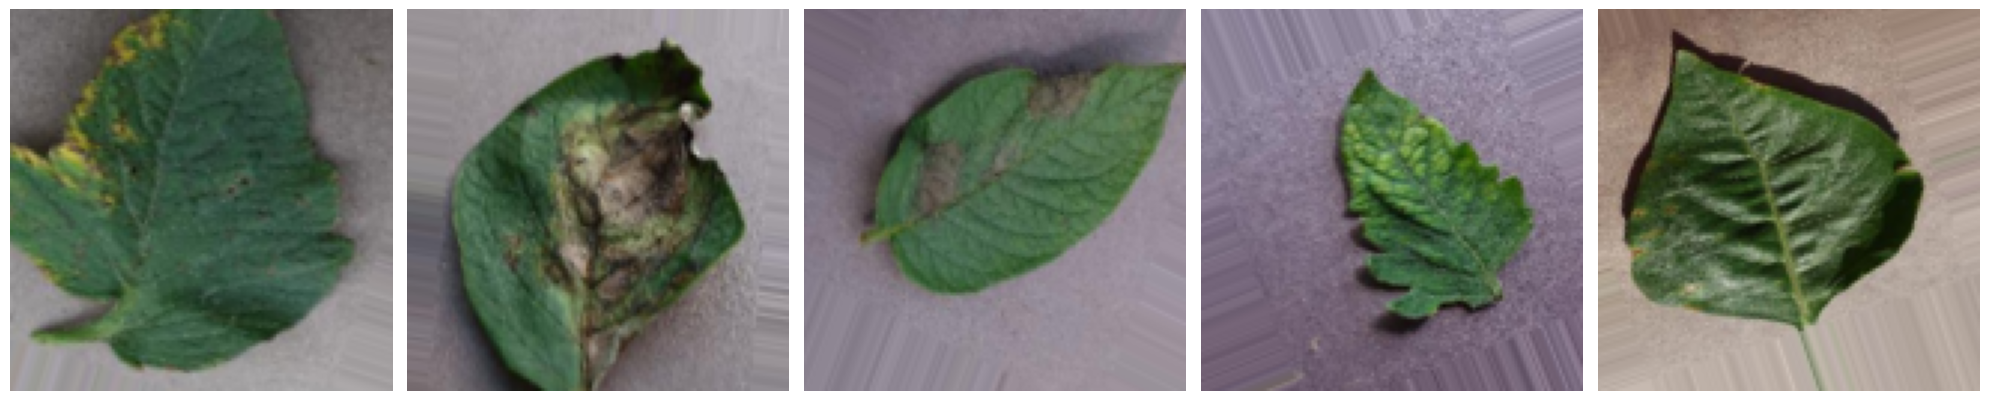

In [9]:
# Wählen Sie eine kleine Stichprobe von Bildern für die Demonstration
X_sample = X_train[:5]

# Erstellen eines Generators für die ausgewählten Beispiele
sample_generator = train_datagen.flow(X_sample, batch_size=1)

# Sammeln der augmentierten Bilder
augmented_images = [sample_generator.next()[0] for _ in range(5)]  # 5 augmentierte Bilder generieren

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):

        # Da img durch rescale modifiziert wurde und matplotlib erwartet, dass die Daten im Bereich [0, 1] liegen,
        # ist keine weitere Anpassung der Bild-Daten notwendig.
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Aufrufen der Funktion mit den augmentierten Bildern
plot_images(augmented_images)


#**Data Modeling**

**Create 1st Model**





In [ ]:
# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

**Create checkpoints and train and save final model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define path for Checkpoints
checkpoint_path = '/content/drive/My Drive/Checkpoints/model_cnn_epoch{epoch:02d}-loss{val_loss:.2f}.h5'

# Create ModelCheckpoint Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


In [ ]:
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=13,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // 32,
    callbacks=[checkpoint_callback]
)


Epoch 1/13
226/226 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.3687
Epoch 1: val_loss improved from inf to 1.19604, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch01-loss1.20.h5
226/226 [==============================] - 304s 1s/step - loss: 1.9645 - accuracy: 0.3687 - val_loss: 1.1960 - val_accuracy: 0.6191
Epoch 2/13
226/226 [==============================] - ETA: 0s - loss: 1.2087 - accuracy: 0.6064
Epoch 2: val_loss improved from 1.19604 to 0.70698, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch02-loss0.71.h5
226/226 [==============================] - 302s 1s/step - loss: 1.2087 - accuracy: 0.6064 - val_loss: 0.7070 - val_accuracy: 0.7588
Epoch 3/13
226/226 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.6899
Epoch 3: val_loss improved from 0.70698 to 0.57893, saving model to /content/drive/My Drive/Checkpoints/model_cnn_epoch03-loss0.58.h5
226/226 [==============================] - 310s 1s

In [ ]:
model_cnn.save('/content/drive/My Drive/model_cnn.h5')

**Create 2nd Model**

Different activation functions and dropout rates.

In [ ]:
model_cnn2 = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model_cnn2.compile(optimizer=RMSprop(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
model_cnn2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

In [ ]:
history = model_cnn2.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // 32
)

Epoch 1/10
226/226 [==============================] - 317s 1s/step - loss: 2.4298 - accuracy: 0.2197 - val_loss: 1.9066 - val_accuracy: 0.3970
Epoch 2/10
226/226 [==============================] - 315s 1s/step - loss: 1.7047 - accuracy: 0.4660 - val_loss: 1.3826 - val_accuracy: 0.5239
Epoch 3/10
226/226 [==============================] - 334s 1s/step - loss: 1.2480 - accuracy: 0.5981 - val_loss: 0.9418 - val_accuracy: 0.6870
Epoch 4/10
226/226 [==============================] - 312s 1s/step - loss: 1.0086 - accuracy: 0.6741 - val_loss: 0.6335 - val_accuracy: 0.7944
Epoch 5/10
226/226 [==============================] - 315s 1s/step - loss: 0.8548 - accuracy: 0.7184 - val_loss: 0.5025 - val_accuracy: 0.8315
Epoch 6/10
226/226 [==============================] - 312s 1s/step - loss: 0.7411 - accuracy: 0.7549 - val_loss: 0.5369 - val_accuracy: 0.8145
Epoch 7/10
226/226 [==============================] - 306s 1s/step - loss: 0.6939 - accuracy: 0.7761 - val_loss: 0.5078 - val_accuracy: 0.8340

In [ ]:
model_cnn2.save('/content/drive/My Drive/model_cnn2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Evaluate Model**

#**Prediction**

In [66]:
from tensorflow.keras.models import load_model

# Replace 'path_to_my_model.h5' with the actual path to your saved model file
model1 = load_model('/content/drive/My Drive/model_cnn.h5')
model2 = load_model('/content/drive/My Drive/model_cnn2.h5')


**Save Test Images in separate file for testing the model**

In [19]:
# IMPORTANT for review! Folder with images already created. Use Link on GitHub

import os

# Pfad zum Zielordner
path_folder = '/content/drive/My Drive/Test_Images'

# Erstellen des Ordners, falls er nicht existiert
if not os.path.exists(path_folder):
    os.makedirs(path_folder)


In [20]:
# IMPORTANT for review! Folder with images already created, do not run again. Use Link on GitHub

# Save test images with their corresponding labels
image_label_map = {}

for i, (images, labels) in enumerate(test_generator):
    for j, image in enumerate(images):
        image_path = os.path.join(path_folder, f'test_image_{i}_{j}.png')
        save_img(image_path, image)
        # Save the label in a dictionary with the filename as the key
        image_label_map[f'test_image_{i}_{j}.png'] = int(np.argmax(labels[j]))  # Convert to Python int
    if i == 0:  # Only save the first batch to limit the number of images
        break

# Optionally, save the image-label map to a file for later use
import json
with open(os.path.join('/content/drive/My Drive', 'image_label_map.json'), 'w') as f:
    json.dump(image_label_map, f)

**Preprocess test image for upload**

In [98]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image /= 255.0  # Rescale the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input
    return image

##**Prediction with both models separately**


In [99]:
# Update this path to your image's path in TestImages
test_image_path = '/content/drive/My Drive/Test_Images/test_image_0_2.png'

# Process the image
processed_image = preprocess_image(test_image_path)


predict = model1.predict(processed_image)
predict2 = model2.predict(processed_image)


print(predict)
print(predict2)



1/1 [==============================] - 0s 354ms/step
[[3.2313827e-13 1.3615556e-07 3.2567814e-14 5.9513714e-14 1.1931166e-16
  9.9955994e-01 3.1118617e-09 8.1692508e-10 6.4213936e-07 1.0377456e-15
  3.5269456e-14 6.9585039e-06 4.3235460e-04 7.0546471e-18 2.0418687e-08]]
[[3.0842242e-03 3.8869011e-08 3.4788169e-08 2.2156212e-06 1.0501532e-05
  9.6355039e-01 3.8335625e-06 1.2420980e-05 1.8960960e-02 1.0241685e-05
  9.1628618e-07 1.1741837e-05 1.4344308e-02 6.8373224e-10 8.2371362e-06]]


**Predict class for each image in test data set folder using both models separately.**

In [100]:
def predict_images_from_folder(path_folder, model1, model2):
    images = []
    predictions1 = []
    predictions2 = []

    # Iterate through each image in the folder
    for filename in os.listdir(path_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):  # Check for image files
            image_path = os.path.join(path_folder, filename)
            image = preprocess_image(image_path)
            pred1 = model1.predict(image)
            pred2 = model2.predict(image)
            predictions1.append(pred1)
            predictions2.append(pred2)
            images.append(filename)

    return images, predictions1, predictions2

In [101]:
# Predict using both models
folder_path = '/content/drive/My Drive/Test_Images'  # Update this to your path
images, predictions1, predictions2 = predict_images_from_folder(folder_path, model1, model2)

# Optionally, print predictions
for img, pred1, pred2 in zip(images, predictions1, predictions2):
    predicted_class1 = np.argmax(pred1, axis=1)[0]
    predicted_class2 = np.argmax(pred2, axis=1)[0]
    print(f"Image: {img}, Prediction by Model 1: {predicted_class1}, Prediction by Model 2: {predicted_class2}")


1/1 [==============================] - 0s 35ms/step
Image: test_image_0_0.png, Prediction by Model 1: 2, Prediction by Model 2: 2
Image: test_image_0_1.png, Prediction by Model 1: 14, Prediction by Model 2: 14
Image: test_image_0_2.png, Prediction by Model 1: 5, Prediction by Model 2: 5
Image: test_image_0_3.png, Prediction by Model 1: 11, Prediction by Model 2: 2
Image: test_image_0_4.png, Prediction by Model 1: 14, Prediction by Model 2: 14
Image: test_image_0_5.png, Prediction by Model 1: 3, Prediction by Model 2: 3
Image: test_image_0_6.png, Prediction by Model 1: 14, Prediction by Model 2: 14
Image: test_image_0_7.png, Prediction by Model 1: 14, Prediction by Model 2: 14
Image: test_image_0_8.png, Prediction by Model 1: 14, Prediction by Model 2: 14
Image: test_image_0_9.png, Prediction by Model 1: 3, Prediction by Model 2: 3
Image: test_image_0_10.png, Prediction by Model 1: 5, Prediction by Model 2: 5
Image: test_image_0_11.png, Prediction by Model 1: 14, Prediction by Model 2: 

##**Prediction with both models combined**

**Shared cell with mapping and functions**

In [102]:
import numpy as np
import os
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Define the class names dictionary
class_names = {
    0: "Tomato Target Spot",
    1: "Potato Early Blight",
    2: "Tomato Yellow Leaf Curl Virus",
    3: "Tomato Healthy",
    4: "Tomato Mosaic Virus",
    5: "Tomato Early Blight",
    6: "Potato Late Blight",
    7: "Tomato Leaf Mold",
    8: "Tomato Septoria Leaf Spot",
    9: "Tomato Spider Mites",
    10: "Tomato Bacterial Spot",
    11: "Pepper Bell Bacterial Spot",
    12: "Tomato Late Blight",
    13: "Potato Healthy",
    14: "Pepper Bell Healthy"
}

# Load the image-label map
with open(os.path.join('/content/drive/My Drive', 'image_label_map.json'), 'r') as f:
    image_label_map = json.load(f)

# Load the models
model1 = load_model('/content/drive/My Drive/model_cnn.h5')
model2 = load_model('/content/drive/My Drive/model_cnn2.h5')

# Define a function to preprocess the image
def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image /= 255.0  # Rescale the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input
    return image

# Define a function to combine predictions from two models with given weights
def weighted_predictions(image_path, model1, model2, weight1=0.6, weight2=0.4):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Get predictions from both models
    pred1 = model1.predict(image)
    pred2 = model2.predict(image)

    # Combine predictions with the specified weights
    combined_pred = weight1 * pred1 + weight2 * pred2

    # Return the combined prediction
    return combined_pred


**Predict All Images in the test Dataset with combined model**


In [112]:
def predict_all_images(folder_path, model1, model2, image_label_map):
    all_y_true = []
    all_y_pred = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            # Get the combined prediction for a single image
            combined_pred = weighted_predictions(image_path, model1, model2)

            # Get the predicted class
            predicted_class = np.argmax(combined_pred, axis=1)[0]

            # Get the true class label from the map
            actual_class = image_label_map[filename]

            all_y_true.append(actual_class)
            all_y_pred.append(predicted_class)

            # Optional: Print the results
            sorted_indices = np.argsort(combined_pred[0])[::-1]
            top_5_indices = sorted_indices[:5]
            top_5_probs = combined_pred[0][top_5_indices]
            print(f"Image: {filename}")
            print(f"Predicted Class: {predicted_class}")
            print(f"Actual Class: {actual_class}")
            print(f"Top 5 Probabilities and Classes:")
            for i, idx in enumerate(top_5_indices):
                print(f"Class {idx}: Probability {top_5_probs[i] * 100:.2f}%")
            print()

    return np.array(all_y_true), np.array(all_y_pred)

# Path to the test images folder
folder_path = '/content/drive/My Drive/Test_Images'

# Predict all images in the test dataset and collect true and predicted labels
all_y_true, all_y_pred = predict_all_images(folder_path, model1, model2, image_label_map)


1/1 [==============================] - 0s 59ms/step
Image: test_image_0_0.png
Predicted Class: 2
Actual Class: 2
Top 5 Probabilities and Classes:
Class 2: Probability 99.27%
Class 11: Probability 0.71%
Class 14: Probability 0.01%
Class 6: Probability 0.01%
Class 9: Probability 0.00%

1/1 [==============================] - 0s 53ms/step
Image: test_image_0_1.png
Predicted Class: 14
Actual Class: 14
Top 5 Probabilities and Classes:
Class 14: Probability 99.95%
Class 13: Probability 0.04%
Class 11: Probability 0.00%
Class 8: Probability 0.00%
Class 12: Probability 0.00%

1/1 [==============================] - 0s 50ms/step
Image: test_image_0_2.png
Predicted Class: 5
Actual Class: 5
Top 5 Probabilities and Classes:
Class 5: Probability 98.52%
Class 8: Probability 0.76%
Class 12: Probability 0.60%
Class 0: Probability 0.12%
Class 11: Probability 0.00%

1/1 [==============================] - 0s 51ms/step
Image: test_image_0_3.png
Predicted Class: 11
Actual Class: 2
Top 5 Probabilities and Cla

**Predict a Single Image in test dataset**


In [104]:
# Function to predict a single image
def predict_single_image(image_path, model1, model2, image_label_map):
    # Get the combined prediction for a single image
    combined_pred = weighted_predictions(image_path, model1, model2)

    # Get the predicted class
    predicted_class = np.argmax(combined_pred, axis=1)[0]
    predicted_prob = combined_pred[0][predicted_class] * 100

    # Get the actual class label from the map
    actual_class = image_label_map[os.path.basename(image_path)]

    # Print the results
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class} ({class_names[predicted_class]}) with {predicted_prob:.2f}% probability")
    print(f"Actual Class: {actual_class} ({class_names[actual_class]})")
    print(f"Top 5 Probabilities and Classes:")
    sorted_indices = np.argsort(combined_pred[0])[::-1]
    top_5_indices = sorted_indices[:5]
    top_5_probs = combined_pred[0][top_5_indices]
    for i, idx in enumerate(top_5_indices):
        print(f"Class {idx} ({class_names[idx]}): Probability {top_5_probs[i] * 100:.2f}%")
    print()

# Path to the specific test image
test_image_path = '/content/drive/My Drive/Test_Images/test_image_0_10.png'

# Predict a single image
predict_single_image(test_image_path, model1, model2, image_label_map)




1/1 [==============================] - 0s 33ms/step
Image: test_image_0_10.png
Predicted Class: 5 (Tomato Early Blight) with 79.45% probability
Actual Class: 5 (Tomato Early Blight)
Top 5 Probabilities and Classes:
Class 5 (Tomato Early Blight): Probability 79.45%
Class 12 (Tomato Late Blight): Probability 16.59%
Class 11 (Pepper Bell Bacterial Spot): Probability 2.68%
Class 14 (Pepper Bell Healthy): Probability 0.40%
Class 0 (Tomato Target Spot): Probability 0.37%



#**Validation**

In [133]:
# Evaluate model with test data from dataset
# Reminder: test_generator = test_datagen.flow(X_test, y_test_one_hot, batch_size=32)

model1.evaluate(test_generator)
model2.evaluate(test_generator)


33/33 [==============================] - 13s 372ms/step - loss: 0.4543 - accuracy: 0.8647


[0.4543227553367615, 0.8647342920303345]

In [122]:
# not all 15 classes (labels) are in the test dataset
import numpy as np

# Check unique classes in the true labels
unique_classes = np.unique(all_y_true)
print("Unique classes in true labels:", unique_classes)

# Classes in the classification report
labels = np.arange(len(class_names))


Unique classes in true labels: [ 0  1  2  3  5  7  9 10 11 12 13 14]


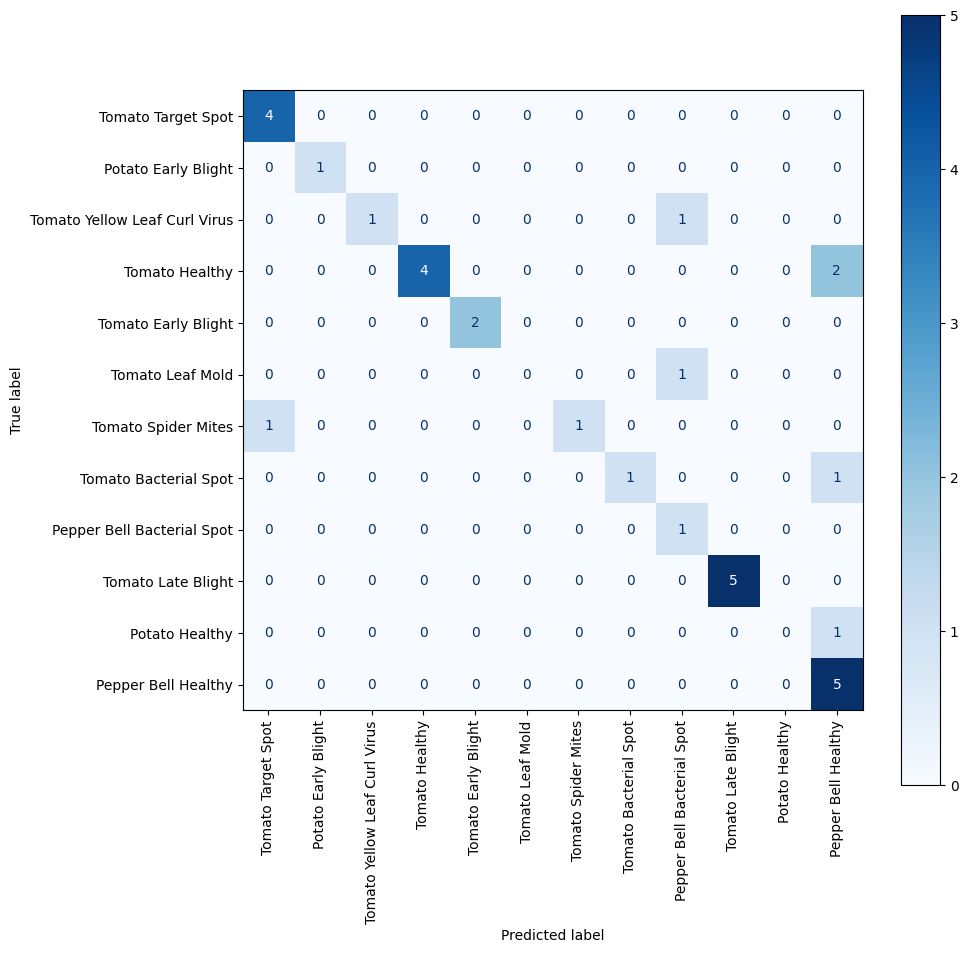

In [129]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[class_names[i] for i in unique_classes])

# Plot confusion matrix and ensure the ticks match the number of classes
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize as needed
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Explicitly set the number of ticks to match the number of classes
tick_marks = np.arange(len(unique_classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels([class_names[i] for i in unique_classes], rotation=90)
ax.set_yticklabels([class_names[i] for i in unique_classes])

plt.show()

In [130]:
# Classification Report
print(classification_report(all_y_true, all_y_pred, target_names=[class_names[i] for i in unique_classes], labels=unique_classes, zero_division=0))


                               precision    recall  f1-score   support

           Tomato Target Spot       0.80      1.00      0.89         4
          Potato Early Blight       1.00      1.00      1.00         1
Tomato Yellow Leaf Curl Virus       1.00      0.50      0.67         2
               Tomato Healthy       1.00      0.67      0.80         6
          Tomato Early Blight       1.00      1.00      1.00         2
             Tomato Leaf Mold       0.00      0.00      0.00         1
          Tomato Spider Mites       1.00      0.50      0.67         2
        Tomato Bacterial Spot       1.00      0.50      0.67         2
   Pepper Bell Bacterial Spot       0.33      1.00      0.50         1
           Tomato Late Blight       1.00      1.00      1.00         5
               Potato Healthy       0.00      0.00      0.00         1
          Pepper Bell Healthy       0.56      1.00      0.71         5

                     accuracy                           0.78        32
    

In [144]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_y_true, all_y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

from sklearn.metrics import precision_score
precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
print(f'Precision: {precision * 100:.2f}%')

from sklearn.metrics import recall_score
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f'Recall: {recall * 100:.2f}%')

from sklearn.metrics import f1_score
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
print(f'F1-Score: {f1 * 100:.2f}%')


Precision: 82.22%
Accuracy: 78.12%
Recall: 78.12%
F1-Score: 76.33%


#**Interpretation**

**Comparision with Benchmark**

A study by Narejo et al. (2020) used VGG16 to detect three tomato leaf
diseases, including bacterial spots, early blight, and healthy leaves. They achieved an accuracy of 94.67% using transfer learning with a pre-trained VGG16 model.

* Accuracy: 0.981
* F1-Score: 0.997
* Macro-Avg: 0.981
* Precision: 0.999
* Recall: 0.997
* Weighted average: 0.981







Source:
- B Pico 1996 Viral diseases causing the greatest economic losses to the tomato crop. ii. the tomato yellow leaf curl
virus—a review Sci Hortic 67 151 196
- Alam, T.S., Jowthi, C.B. & Pathak, A. Comparing pre-trained models for efficient leaf disease detection: a study on custom CNN. Journal of Electrical Systems and Inf Technol 11, 12 (2024). https://doi.org/10.1186/s43067-024-00137-1
